In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm


from dataset import MNIST_Moving
from encoder import Embedded_Encoder
from decoder import Embedded_Decoder
from conv_lstm import ConvLSTM
from model import Model

from torchsummary import summary

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
train_set = MNIST_Moving(root='.data/mnist', train=True, download=True)
test_set = MNIST_Moving(root='.data/mnist', train=False, download=True)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [9]:
input= next(iter(train_loader))
print("The shape of the input is ", input.shape)

vid_seq = input[0]
print("The shape of the video seq is", vid_seq.shape)



The shape of the input is  torch.Size([100, 20, 1, 64, 64])
The shape of the video seq is torch.Size([20, 1, 64, 64])


In [5]:
model = Model()

In [ ]:
# test_tensor = torch.rand((20, 1, 64, 64)).to(device)
# model(test_tensor).shape

torch.Size([20, 1, 64, 64])

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

In [27]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, full_seq in progress_bar:
        for batch_iterator in range (0,batch_size):
          each_seq = full_seq[batch_iterator,:,:,:,:].type(torch.FloatTensor).to(device)
          target_seq = each_seq[10:,:,:,:]
         
        
          # Clear gradients w.r.t. parameters
          optimizer.zero_grad()
        
          # Forward pass only to get logits/output
          outputs = model(each_seq)
          outputs = outputs.to(device)
         
          # Calculate Loss: softmax --> cross entropy loss
          loss = criterion(outputs[10:, :, :, :], target_seq)
          loss_list.append(loss.item())
        
          # Getting gradients w.r.t. parameters
          loss.backward()
         
          # Updating parameters
          optimizer.step()
        
          progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list

In [ ]:
loss_list = train_epoch(model, train_loader, optimizer, criterion, 0, device)

Epoch 1 Iter 42: loss 2425.02222. :  46%|████▌     | 41/90 [1:05:32<1:18:17, 95.87s/it]

In [ ]:
from torchvision.utils import make_grid
import torchvision.transforms.functional as Func
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def visualize_results(model, test_loader, device):
    test_input = next(iter(test_loader)).squeeze(0).type(torch.FloatTensor).to(device)
    out_ = model(test_input)
    out_ = out_.to(device)
    grid = make_grid(out_)
    show(grid)    

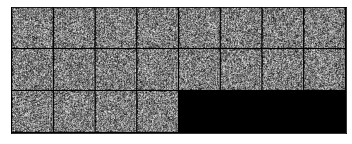

In [ ]:
visualize_results(model, test_loader, device)